In [1]:
from trainer import Trainer
import constants


import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


/local/users/unjde


In [2]:

embeddings = {}
text_labels = []
raw_text_labels_files = []

for file_path in constants.file_paths:
    with open(file_path + "_embeddings_.json", "r") as f:
        embeddings_objects = json.load(f)
        for emb_obj in embeddings_objects:
            embeddings[emb_obj["hash"]] = np.array(emb_obj["embeddings"])

    with open(file_path + "_labeled_fewer_classes.json", "r") as f:
        text_labels_file = json.load(f)
        raw_text_labels_files.append({'ds': file_path, 'raw': text_labels_file})
        for text_hash, doc_info in text_labels_file.items():
            labels_list = [label["system"] for label in doc_info["label"]]
            text_labels.append((text_hash, labels_list))



In [3]:
# Assuming your initial data processing steps
filtered_embeddings = []
filtered_text_labels = []
doc_values_initial = []
doc_values = []

for item in raw_text_labels_files:
    raw_data = item.get('raw', {})
    for key, value in raw_data.items():
        doc_value = value.get('doc')
        if doc_value:
            doc_values_initial.append(doc_value)

for i, (sample_id, classes) in enumerate(text_labels):
    if classes:
        for label in classes:
            filtered_embeddings.append(embeddings[sample_id])
            filtered_text_labels.append(label)
            doc_values.append(doc_values_initial[i])



In [4]:
%pip install top2vec nltk

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install top2vec[sentence_encoders]

Note: you may need to restart the kernel to use updated packages.


In [6]:
from top2vec import Top2Vec


2024-09-22 16:49:14.083370: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 16:49:14.095734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 16:49:14.110065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 16:49:14.114294: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 16:49:14.124596: I tensorflow/core/platform/cpu_feature_guar

In [7]:
import nltk
nltk.download('stopwords')

def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopwords]
    return text
def tok(text):
    import gensim
    text = gensim.utils.simple_preprocess(text)
    text = remove_stopwords(text)
    return text
#topic_model = Top2Vec(
#     doc_values,
#     embedding_model="universal-sentence-encoder",
#     speed="deep-learn",
#     tokenizer=tok,
#     ngram_vocab=True,
#     ngram_vocab_args={"connector_words": "phrases.ENGLISH_CONNECTOR_WORDS"},
# )

[nltk_data] Downloading package stopwords to
[nltk_data]     /local/users/unjde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
model_path = 'model/topic2vec'

topic_model = Top2Vec.load(model_path)
topic_model.save(model_path)

In [9]:
topic_model.get_num_topics()

35

In [10]:
topic_words, word_scores, topic_nums = topic_model.get_topics(35)

In [11]:

document_topics, scores, words, topic_word_emb = topic_model.get_documents_topics(doc_ids=list(range(len(doc_values))))

In [12]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
document_topics_one_hot = one_hot_encoder.fit_transform(np.reshape(document_topics, (-1,1)))

In [13]:
from scipy.sparse import csr_matrix

sparse_matrix = csr_matrix(document_topics_one_hot).toarray()

In [14]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_text_labels)


X_topics = np.array(sparse_matrix)




In [15]:

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

In [16]:

import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /local/users/unjde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:

english_stemmer = nltk.stem.SnowballStemmer('english') 
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([english_stemmer.stem(w) for w in analyzer(doc)])

def train_bert(docs,model_path):
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Clustering model: See [2] for more details
    cluster_model = HDBSCAN(min_cluster_size = 15, 
                            metric = 'euclidean', 
                            cluster_selection_method = 'eom', 
                            prediction_data = True)
    
    #Explicitly define, use, and adjust the ClassTfidfTransformer with new parameters, 
    #bm25_weighting and reduce_frequent_words, to potentially improve the topic representation
    ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)                         
    #vectorizer_model = CountVectorizer(ngram_range=(1, 2),stop_words=stopwords)
    vectorizer_model = StemmedCountVectorizer(analyzer="word",stop_words=stopwords, ngram_range=(1, 2))

    # BERTopic model
    topic_model = BERTopic(embedding_model = embedding_model,
                           hdbscan_model = cluster_model,
                           ctfidf_model=ctfidf_model,
                           vectorizer_model=vectorizer_model,
                           language="english")

    # Fit the model on a corpus
    topics, probs = topic_model.fit_transform(docs)
    topic_model.save(model_path)
    return topic_model


In [18]:
model_path_bad = 'model/bert_bad'
#topic_model_bad = train_bert(doc_values,model_path_bad)
topic_model_bad = BERTopic.load(model_path_bad)

In [19]:

document_topics_bert = topic_model_bad.get_document_info(doc_values)["Topic"].tolist()

In [20]:

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder_bert = OneHotEncoder()
document_topics_one_hot_bert = one_hot_encoder_bert.fit_transform(np.reshape(document_topics, (-1,1)))

In [21]:

sparse_matrix_bert = csr_matrix(document_topics_one_hot_bert).toarray()

In [22]:
X_topics_bert = np.array(sparse_matrix_bert)

In [23]:
def evaluate(X, y):
    result = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    trainer = Trainer()
    trainer.train(X_train, y_train)

    predictions = trainer.predict(X_test)


    class_names = label_encoder.classes_

    for name, preds in predictions.items():
        accuracy, f1, recall = trainer.evaluate(y_test, preds)
        result[name] = {'accuracy': accuracy}
        print(f"{name} accuracy: {accuracy}, f1 score: {f1}, recall: {recall}")

    for name, preds in predictions.items():
        cm = confusion_matrix(y_test, preds)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

    print(trainer.get_best_params())
    return result

In [24]:
results_dict = {}

----------------- evaluate: one hot top2vec ---------------------
Training dummy_mf...


Training dummy_un...
Training random_forest...
Training svm...
Training knn...
Training mlp...
dummy_mf accuracy: 0.23537871524448706, f1 score: 0.08969417864574555, recall: 0.23537871524448706
dummy_un accuracy: 0.12943432406519656, f1 score: 0.13871874699134143, recall: 0.12943432406519656
random_forest accuracy: 0.4290508149568552, f1 score: 0.32609988986534966, recall: 0.4290508149568552
svm accuracy: 0.4290508149568552, f1 score: 0.3283881972777535, recall: 0.4290508149568552
knn accuracy: 0.42377756471716205, f1 score: 0.33319005212887504, recall: 0.42377756471716205
mlp accuracy: 0.43384467881112176, f1 score: 0.32415666872253784, recall: 0.43384467881112176


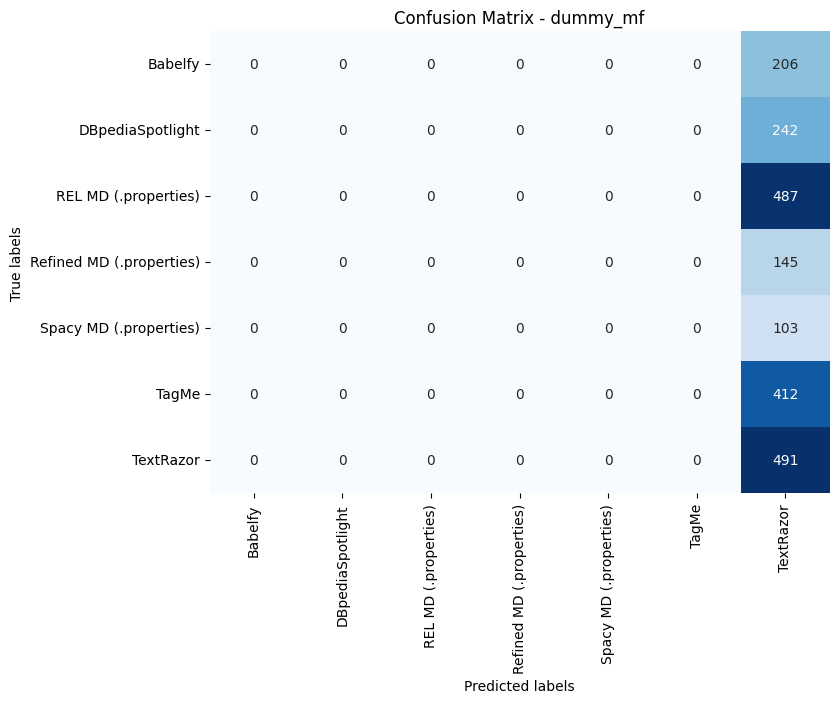

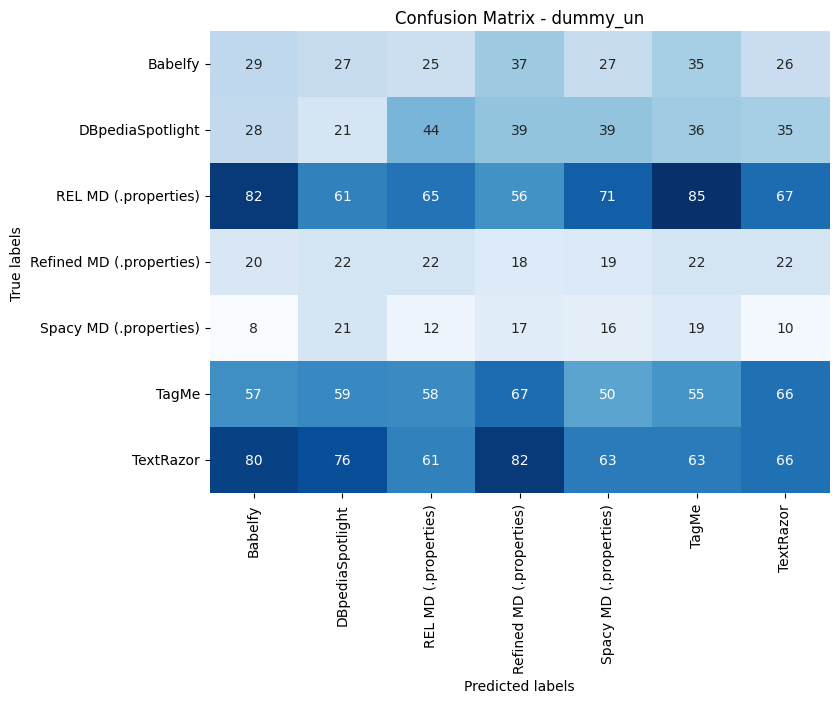

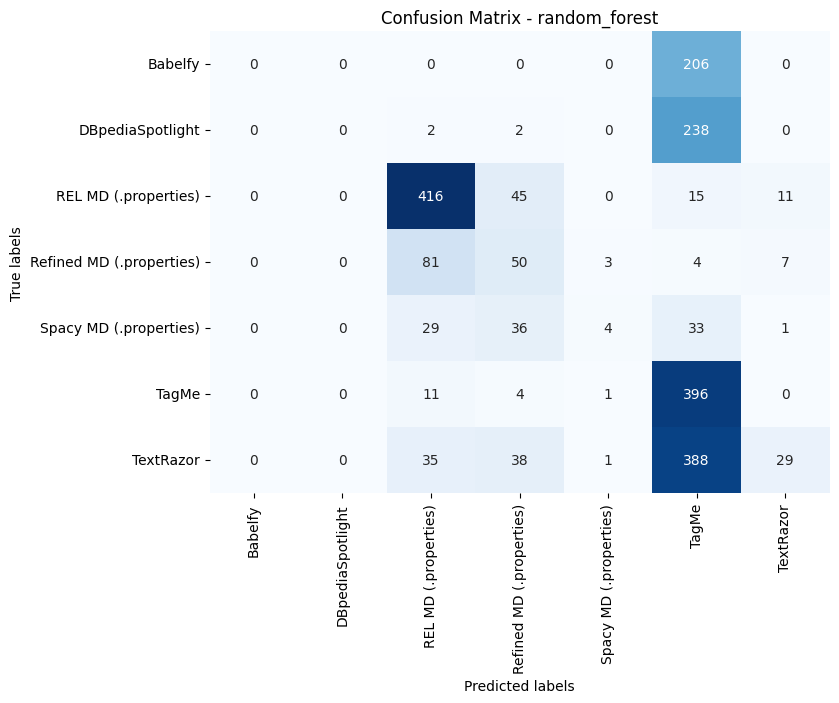

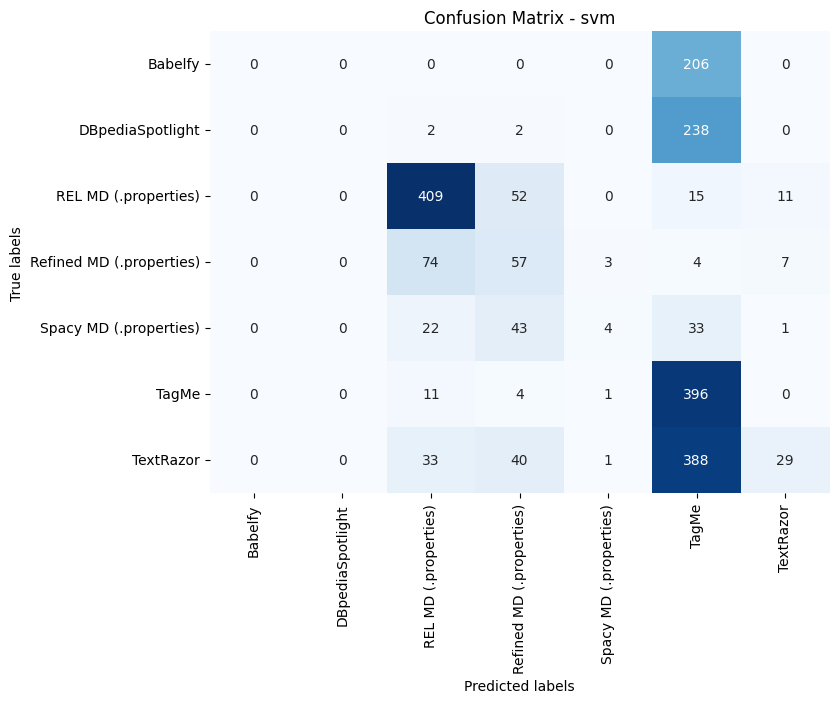

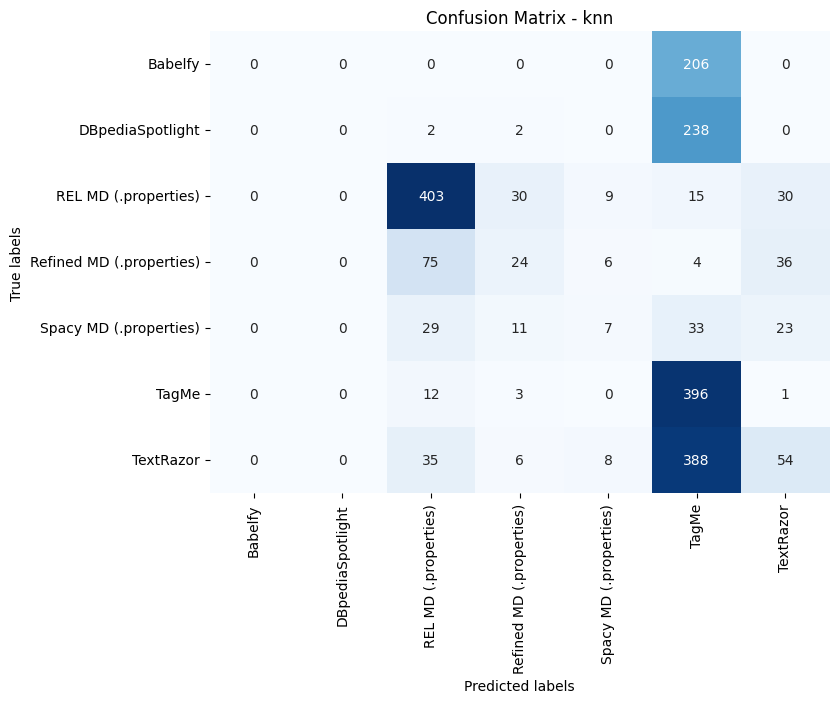

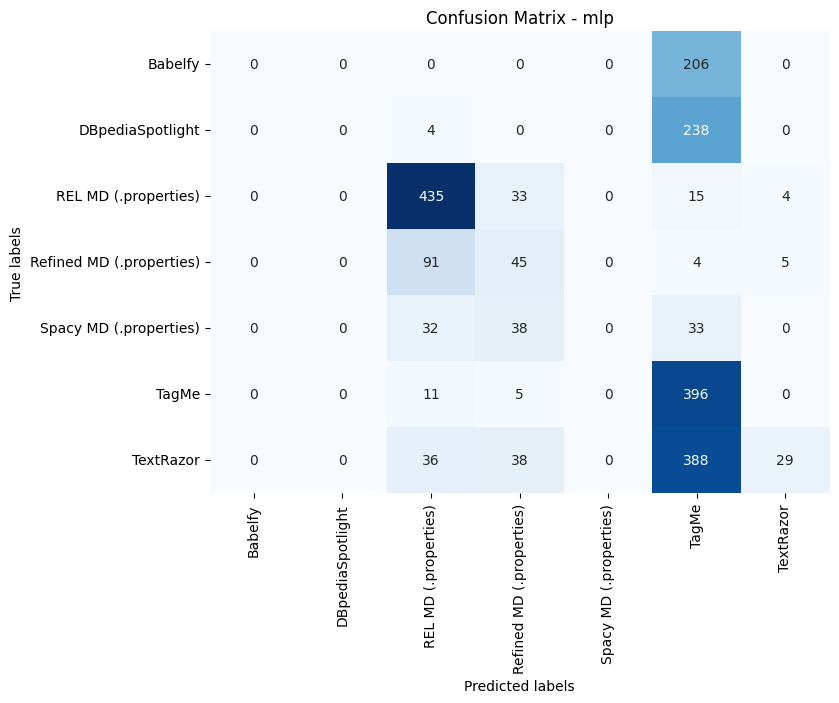

{'dummy_mf': {}, 'dummy_un': {}, 'random_forest': {'max_depth': 30, 'n_estimators': 100}, 'svm': {'C': 1, 'kernel': 'linear'}, 'knn': {'n_neighbors': 7, 'p': 1}, 'mlp': {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'solver': 'sgd'}}


In [25]:
print("----------------- evaluate: one hot top2vec ---------------------")
results_dict['top2vec'] = evaluate(X_topics, y)

Training dummy_mf...
Training dummy_un...
Training random_forest...
Training svm...
Training knn...
Training mlp...
dummy_mf accuracy: 0.23537871524448706, f1 score: 0.08969417864574555, recall: 0.23537871524448706
dummy_un accuracy: 0.13998082454458294, f1 score: 0.15153513655910344, recall: 0.13998082454458294
random_forest accuracy: 0.4290508149568552, f1 score: 0.3283881972777535, recall: 0.4290508149568552
svm accuracy: 0.4290508149568552, f1 score: 0.3283881972777535, recall: 0.4290508149568552
knn accuracy: 0.42377756471716205, f1 score: 0.33319005212887504, recall: 0.42377756471716205
mlp accuracy: 0.4290508149568552, f1 score: 0.3374720982040787, recall: 0.4290508149568552


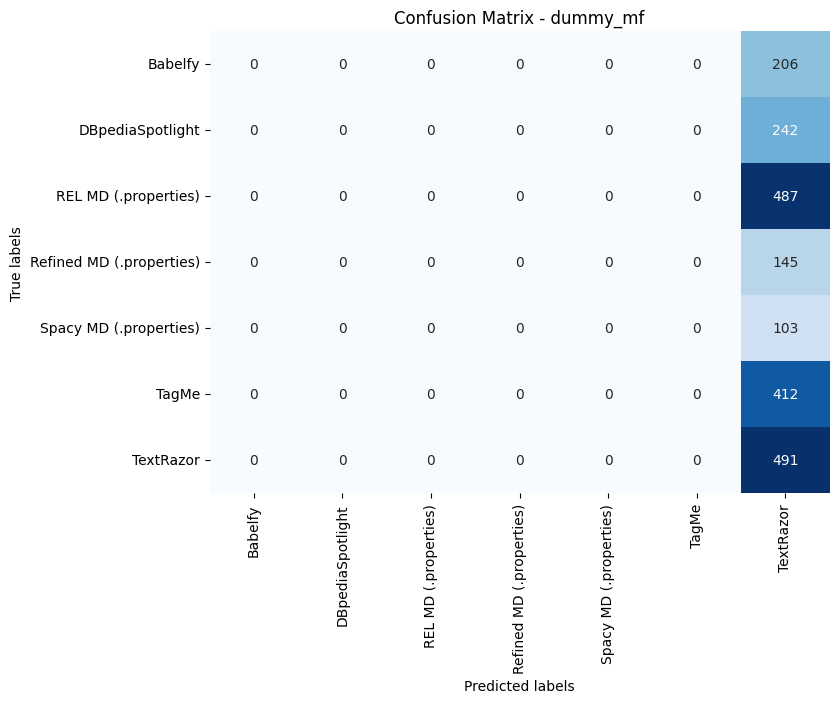

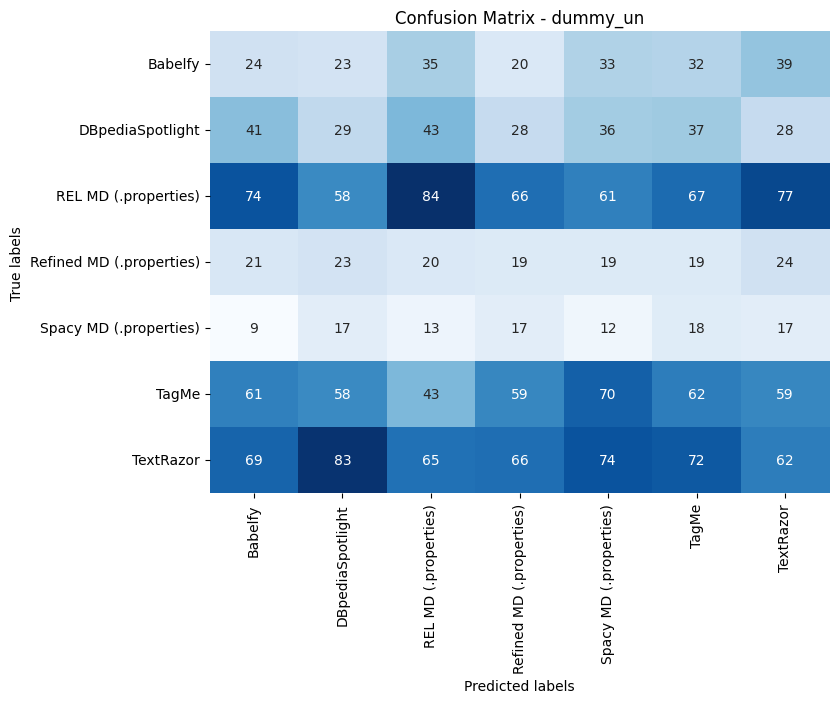

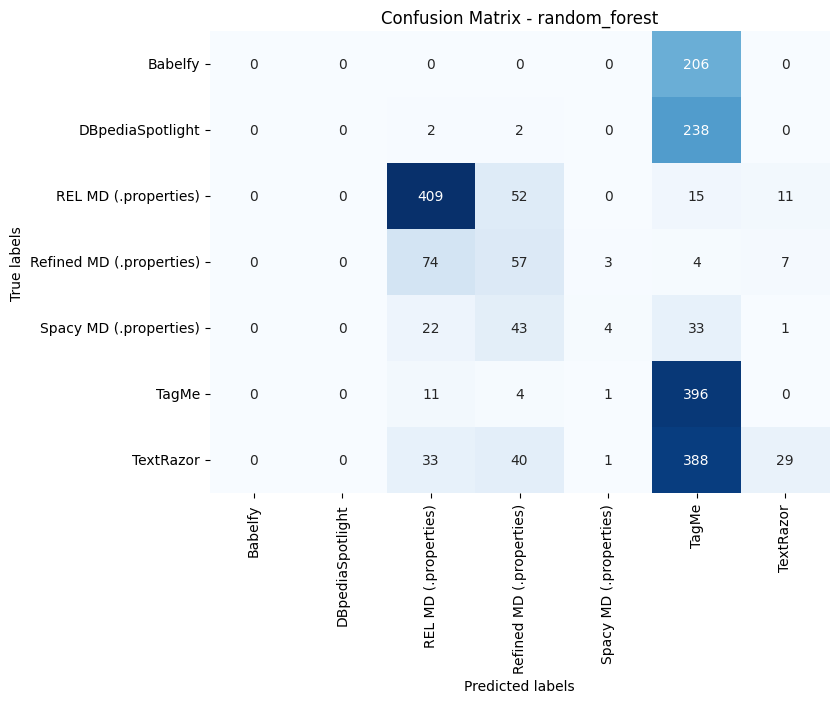

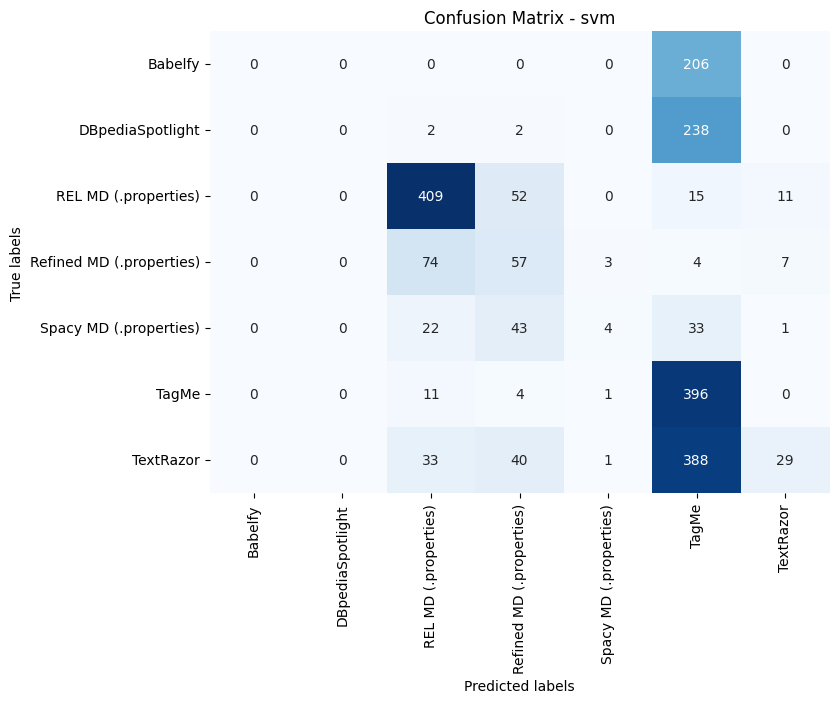

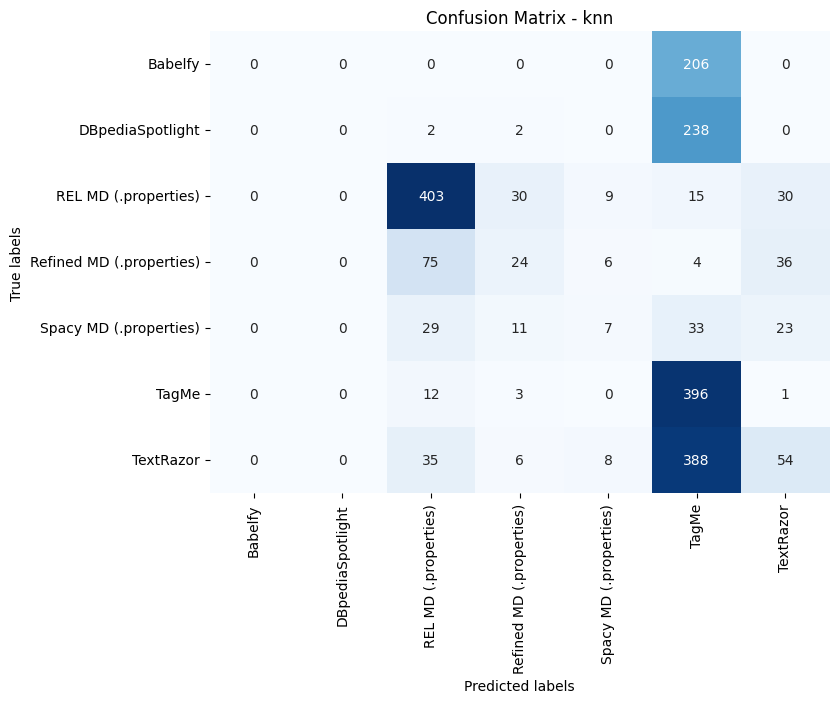

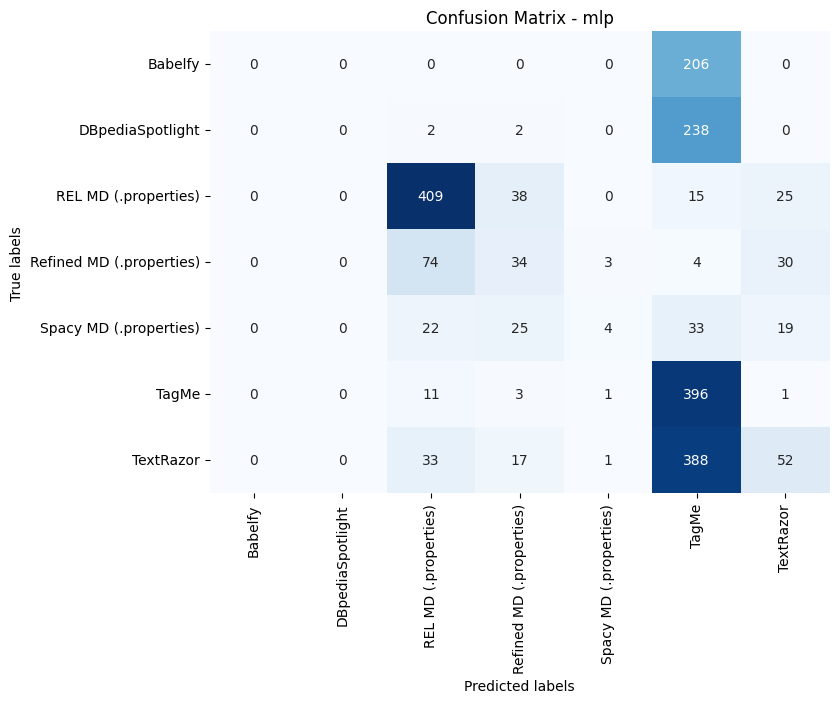

{'dummy_mf': {}, 'dummy_un': {}, 'random_forest': {'max_depth': None, 'n_estimators': 200}, 'svm': {'C': 1, 'kernel': 'linear'}, 'knn': {'n_neighbors': 7, 'p': 1}, 'mlp': {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}}


In [26]:
results_dict['bertopic'] = evaluate(X_topics_bert, y)

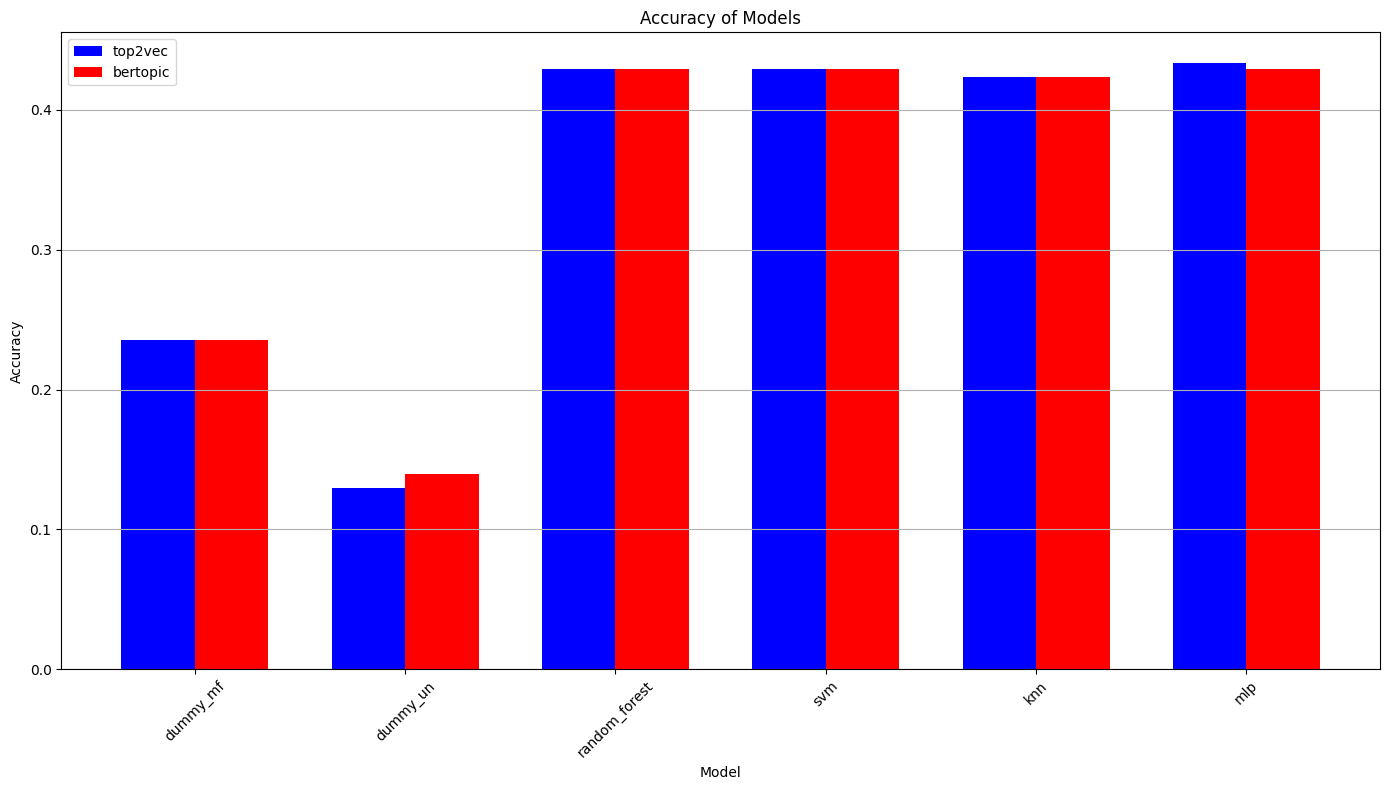

In [27]:
import matplotlib.pyplot as plt
import numpy as np

models = list(results_dict['top2vec'].keys())

accuracy_top2vec = [results_dict['top2vec'][model]['accuracy'] for model in models]
accuracy_bertopic = [results_dict['bertopic'][model]['accuracy'] for model in models]

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(14, 8))
plt.bar(index, accuracy_top2vec, bar_width, label='top2vec', color='b')
plt.bar(index + bar_width, accuracy_bertopic, bar_width, label='bertopic', color='r')

plt.xticks(index + bar_width / 2, models, rotation=45)
plt.title('Accuracy of Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()

plt.show()
